In [13]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as mplib
import thinkdsp
import bpsk
from array import array

%matplotlib inline

# This function converts a string into a numpy array of bits
# note that it is assumed that each character is 7 bits long here
def string2NPArray(s):
    bits = np.array([])
    for a in bytearray(s, 'ascii'):
        for b in range(0,7):
            bits = np.append(bits,float((a>>(7-b-1))&1))
    return bits

# This function converts a numpy array of bits to a string
# note that it is assumed that each character is 7 bits long here
def NPbits2String(bits):
    S = ""
    for a in np.arange(0, np.ceil(len(bits)/7)):
        tmp = 0
        for k in np.arange(0,7):
            b = bits[a*7+k]
            tmp = tmp + (2**(6-k))*b
        S = S + chr(int(tmp))
    return S

# this function is used to help convert numpy array data into a format
# suitable for writing into a wave file
def convert_to_int16(sig):
    # convert into int16  to write as wave
    sig = (sig/np.max(sig))*(2**14)
    sig = sig.astype('int16')
    return sig


# this is a utility function that  finds the start and  end 
# of transmission in the numpy array of samples xf
# The function looks for the first instance where the entries of xf
# go above threshold and returns the index into xf where this happens
# in start_idx
# The function looks for the last instance where the entries of xf
# are above threshold and returns the index into xf where this happens
# in end_idx
# 
# You will probably have to do some trial and error to get the threshold right
# one possibility is to se the threshold equal to some factor of the maximum value
# in the input signal,  e.g. 0.3 * maximum value in xf
#
def find_start_and_end(xf, threshold = 2000): 
    import numpy as np    
    start_idx = -1
 
    for k in range(0, len(xf)):
        if(np.abs(xf[k])) > threshold:
            start_idx = k
            break

    if(start_idx  < 0):
        print "Unable to detect start of transmission"
        return -1
    
    end_idx = -1
    
    for k in range(0, len(xf)):
        if(np.abs(xf[len(xf)-k-1])) > threshold:
            end_idx = len(xf)-k-1
            break

    if(end_idx < 0):
        print "Unable to detect end of transmission"
        return -1

    return start_idx, end_idx



def record_from_mic_windows(duration = 10, filename = 'AcousticModemRx.wav'):

    import subprocess
    import time
    cmd = "SoundRecorder /FILE %s /DURATION 0000:00:%2d" % (filename, duration)
    print subprocess.check_output(cmd, shell=True)

    # wait for the recording to complete
    time.sleep(duration+2)
  
    # because soundrecorder in windows cannot set the sample rate 
    # we have to manually resample here

    # read the wave file into sig      
    fs, sig = wavfile.read(filename)
    
    
    # if fs not 44100, return an error
    if (fs != 44100):
        print "Sample rate must be 44100. Found it to be %d" % fs
        print "Please change it in Windows Control Panel -> Sound -> Recording -> Microphone -> Advanced"
        return
    
    # discard one of the stereo channels
    sig = sig[:,0]
    
    # make a lowpass filter with cutoff 4410
    # this is going to be our anti-aliasing filter
    ts = np.arange(0, len(sig)/float(fs), 1/float(fs))
    filt = np.sinc(np.arange(-64/float(fs), 64/float(fs), 1/float(fs))/np.pi * 4410.0*2*np.pi)
    
    # lowpass filter the signal to avoid inadvertent aliasing
    sig_down = np.convolve(filt, sig)
    
    # Downsample by 5 to go from 44100 -> 8820Hz
    sig_down = sig_down[0:len(sig_down): 5]
     
    return (8820, sig_down)



def record_from_mic_linux(duration = 10, filename = 'AcousticModemRx.wav', rate = 8820):
    import subprocess
    import time
    
    # call arecord
    cmd = "arecord -d %d -r %d %s" %(duration, rate, filename)   
    subprocess.check_output(cmd, shell=True)
    # wait for the recording to complete
    time.sleep(duration+2)
    fs, x = wavfile.read(filename)
    return (fs,x)


You should first generate a BPSK transmitted signal on a different computer using AcousticModemTransmitter-NoPyAudio
Before you hit play the audio signal on that computer, you should start recording the microphone input on your receiver computer (i.e. this one).  This will ensure that you do not miss the beginning of the transmission. 

You can record the audio signal using an audio recording program such as audacity (windows/linux), or arecord(linux if you have ALSA) and save it to AcousticModemRx.wav You should use 16bit-PCM data, a sample rate of 8820Hz and mono to make the recording. If you are running on windows, you can use record_from_mic_windows defined above.

In Linux if you have ALSA installed, you can run arecord AcousticModemRx.wav to record and hit control-C to stop recording. 

In the following cell, the received BPSK audio signal is processed to decode the message. It is assumed that the audio signal is stored in AcousticModemRx.wav

The BPSK bits are decoded using decode_bpsk_signal from the bpsk module. 

Your job is to design your own version of the  transmitter and decode_bpsk_signal. 

You will likely have to tweak the detection_threshold_factor here to make it work reliably for your set of computers/physical environment.

In [3]:
def decode_bpsk_signal(x, freq=1000, rate = 8000, symbol_len = 250, detection_threshold_factor = 0.3, LPFbw = 320):
    """
     Decodes a received BPSK signal in vector x and produces a numpyarray of bits 
     The function uses a brute-force approach to carrier phase synchronization by checking 16 evenly spaced
     phase offsets between -pi and pi to find the one which results in the strongest demodulated signal
     which is then used as the demodulated signal
     The first bit is assumed to be a control bit that always equals 1. This bit is not returned in the final output
     x - a numpy array of the received audio samples
     freq - carrier frequency 
     rate - sample rate used 
     symbol_len - length in samples of the rectangular pulse
     detection_threshold_factor - this is used for detecting the start and end of transmission
                                  the start of transmission is the first sample that exceeds
                                  detection_threshold_factor times the maximum value in x
                                  the end of transmission is the last sample that exceeds
                                  detection_threshold_factor times the maximum value in x
     LPFbw - this is the bandwidth in rad/sec of the low-pass filter that is used after
             multiplying with a cosine
    """
    w = 2*np.pi*freq
    ts = np.arange(0, len(x)/float(rate), 1/float(rate))
    offsets=np.linspace(-np.pi,np.pi,16)
    max_amps=np.empty(16)
    for p in range(len(offsets)): #Loop selects best phase offset.
        tmp=x*np.cos(w * (ts - offsets[p]))
        max_amps[p]=tmp.max()
    phi=offsets[max_amps.argmax()]
    
    (start,end)=find_start_and_end(x, threshold = detection_threshold_factor*max_amps.max())
    signal=x[start:end+1] #Use provided function to find start and end.
    ts = np.arange(0, len(signal)/float(rate), 1/float(rate))
    demod=signal*np.cos(w * (ts - phi)) #Multiply by the cosine to demodulate the signal.
    filt=np.fft.ifft(np.fft.fft(demod)*np.concatenate((np.ones(LPFbw),np.zeros(len(demod)-LPFbw)))) #LP with cutoff=LPFbw
    #filt=filt[0:len(filt)-len(filt)%symbol_len] #Cut into a length that's evenly divisble by symbol_length.
    bit_arr=[]
    for c in range((len(filt)/symbol_len)+1): #Iterate through filtered array, symbol_len items at a time.
        avg=np.mean(filt[c*symbol_len:(c+1)*symbol_len])
        if avg>0:
            bit_arr.append(1)
        elif avg<=0:
            bit_arr.append(0)
    
    return (ts,filt,np.array(bit_arr[1:],dtype=np.float32))
    

In [71]:
record_from_mic_linux(duration = 3, filename = 'AcousticModem_OTA_inline.wav', rate = 8820)

(8820, array([128, 128, 128, ..., 132, 132, 132], dtype=uint8))

In [10]:

# if you are running on windows, you can uncomment this line to record from the mic for 10s
# using windows soundrecorder. Make sure that windows soundrecorder is not already running
# and set the sample rate in Control Panel -> Sound -> Recording -> Microphone -> Advanced
# to 44100
# you can then comment out the subsequent line 

# fs, x = record_from_mic_windows(duration = 10, filename = 'AcousticModemRx.wav')

#fs, x = wavfile.read('AcousticModemTx_ZG.wav')
fs, x = wavfile.read('AcousticModem_OTA.wav') #This file recorded in Audacity from mic and saved as wav.

# decode received signal into a numpy array of bits
#bits = bpsk.decode_bpsk_signal(x, freq=1000, rate = fs, symbol_len = 250, detection_threshold_factor = 0.4, LPFbw = 320)

(time,filtered,bits) = decode_bpsk_signal(x, freq=1000, rate = fs, symbol_len = 250, detection_threshold_factor = 0.3, LPFbw = 320)
#print len(bits)
#print bits1
#print bits2
#mplib.plot(x)
#mplib.plot(bits2)
#mplib.show()
# convert the numpy array of bits into a string
message_string = NPbits2String(bits)
# print the decoded string
print message_string


Hello


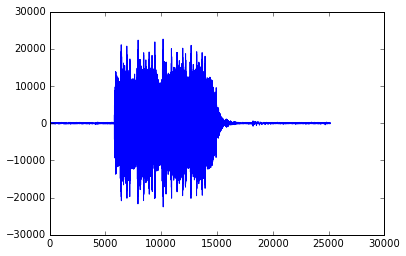

In [14]:
f0=mplib.figure()
ax = fig.add_subplot(111)
ax.set_title('Raw Recorded Signal')
ax.set_xlabel('Time (sample#)')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(x)
mplib.show()

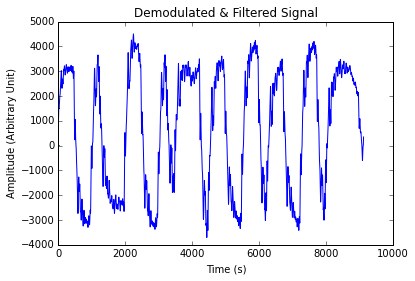

In [15]:
fig=mplib.figure()
ax = fig.add_subplot(111)
ax.set_title('Demodulated & Filtered Signal')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(filtered)
mplib.show()


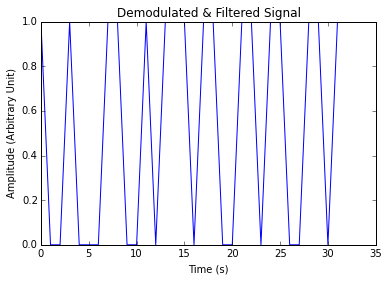

In [16]:
b=mplib.figure()
ax = b.add_subplot(111)
ax.set_title('Demodulated & Filtered Signal')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(bits)
mplib.show()